In [1]:
import numpy as np
import xarray as xr
import warnings
from joblib import Parallel, delayed
from pathlib import Path

from pyorg.core.geometry import get_cells_area

import pycompo.core.coord as pccoord
import pycompo.core.ellipse as pcellipse
import pycompo.core.feature_cutout as pcfeatcut
import pycompo.core.filter as pcfilter
import pycompo.core.plot as pcplot
import pycompo.core.sst_features as pcsst
import pycompo.core.wind as pcwind

from pycompo.core.composite import interpolate2compo_coords
from pycompo.core.utils import read_yaml_config, circ_roll_avg

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_template.yaml"
config = read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
feature_var = config['data']['feature_var']

### Read in data, building SST anomalies and their gradients using Gaussian filter

#### Infos on the filtering in degree space
Here we use a characteristic wavelength in degree since this has three advantages:
1) We remove the necessity to transform to km and can easily use a Gaussian filter
2) Ocean eddies - and thus temperature anomalies - tend to become smaller towards higher latitudes due to the Coriolis effect. Thus, cutting at a certain wavenumber instead of a certain wavelength is also physically reasonable.
3) We are in the deep tropics where the difference between longitudes and distances is small anyways.

Nevertheless, the charcateristic wavenumber has to be submitted as a characteristic wavelength at the equator -- it will be transformed internally.

In [ ]:
varlist = [feature_var] + config['data']['wind_vars'] + \
    config['data']['study_vars']

infiles = []
for var in varlist:
    inpath = Path(config['data']['inpaths'][var])
    in_pattern = \
        f"{config['exp']}_tropical_{var}_20200801T000000Z-20200901T000000Z.nc"
        #f"{config['exp']}_tropical_{var}_{start_time}-{end_time}.nc"
    infiles.extend(sorted([str(f) for f in inpath.rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()
dset = dset.isel(time=slice(0, 2))
for var in varlist: dset[var] = dset[var].compute()

# Detrend data with climatology
if config['detrend']['switch']:
    feature_var = config['data']['feature_var']

    # Read in data for building the climatology
    inpath = Path(config['data']['inpaths'][feature_var])
    in_pattern = f"{config['exp']}_tropical_{feature_var}_*.nc"
    infiles = sorted([str(f) for f in inpath.rglob(in_pattern)])
    dset_clim = xr.open_mfdataset(infiles, parallel=True).squeeze()
    
    # Detrend dataset with multiyear monthly climatology
    climatology = pcfilter.build_hourly_climatology(
        dset_clim, clim_baseyear=str(config['detrend']['clim_baseyear'])
        )
    rolling_climatology = circ_roll_avg(
        climatology, config['detrend']['clim_avg_days'], config['data']['spd'],
        )
    dset[f'{feature_var}_detrend'] = \
        dset[feature_var] - rolling_climatology[feature_var]
    dset[f'{feature_var}_detrend'] = dset[f'{feature_var}_detrend'].compute()
    config['data']['feature_var'] = f'{feature_var}_detrend'
    
# Gaussian filter to extract anomalies
filter_vars = [feature_var] + config['data']['study_vars']
dset = xr.merge([
    dset,
    pcfilter.get_gaussian_filter_bg_ano(dset[filter_vars], **config['filter'])
    ])
keep_vars = [f"{var}_ano" for var in filter_vars] + config['data']['wind_vars']
dset = dset[keep_vars]

dset = pccoord.calc_sphere_gradient_laplacian(dset, f'{feature_var}_ano')

dset['cell_area'] = get_cells_area(dset)
dset = dset.sel(lat=slice(*config['lat_range']), drop=True)

In [15]:
dset

<xarray.Dataset>
Dimensions:           (time: 2, lat: 340, lon: 4080)
Coordinates:
  * time              (time) datetime64[ns] 2020-08-01 2020-08-01T03:00:00
  * lat               (lat) float64 -14.96 -14.87 -14.78 ... 14.78 14.87 14.96
  * lon               (lon) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
    height_2          float64 10.0
    lon_rad           (lon) float64 -3.141 -3.139 -3.138 ... 3.138 3.139 3.141
    lat_rad           (lat) float64 -0.2611 -0.2596 -0.258 ... 0.2596 0.2611
Data variables: (12/15)
    ts_ano            (time, lat, lon) float32 nan nan nan ... 0.05942 0.05145
    pr_ano            (time, lat, lon) float32 nan nan nan ... -0.4669 7.872
    prw_ano           (time, lat, lon) float32 nan nan nan ... 0.1374 0.6131
    hfls_ano          (time, lat, lon) float32 nan nan nan ... 10.76 6.19 8.655
    hfss_ano          (time, lat, lon) float32 nan nan nan ... -0.6738 -0.6749
    rlut_ano          (time, lat, lon) float32 nan nan nan ... 23.26 27.08 26.61
    ...                ...
    ps_ano            (time, lat, lon) float32 nan nan nan ... 7.633 7.391 7.867
    uas               (time, lat, lon) float32 -9.22 -9.106 ... -6.573 -6.486
    vas               (time, lat, lon) float32 2.463 2.464 ... 0.8293 0.9229
    dts_ano_dx        (time, lat, lon) float64 nan nan ... -1.246e-06 -8.403e-07
    dts_ano_dy        (time, lat, lon) float32 nan nan ... 9.763e-07 8.24e-07
    ts_ano_laplacian  (time, lat, lon) float64 nan nan ... -1.186e-10 -9.022e-11

### Visualization of the different SST preprocessing steps

In [18]:
if config['detrend']['switch']:
    # User settings of spatiotemporal plotting area
    lat_slice = slice(0, 10)
    lat_slice = slice(-15, 15)
    lon_slice = slice(-170, -160)
    lon_slice = slice(-179, -140)
    time_index = 0

    pcplot.plot_preprocessing_overview_map(
        dset.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice),
        config['data']['feature_var'], config['feature']['threshold'], 
        )

### Detection of SST clusters and cutout of corresponding data

#### Parallel

In [ ]:
import pycompo.core.utils as pcutil

def process_one_timestep(dset, time, config):
    data = dset.sel(time=time)
    feature_var = config['data']['feature_var']
    data[f"{feature_var}_feature"], feature_props = pcsst.extract_sst_features(
        data[f"{feature_var}_ano"], **config['feature']
        )
    data, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
        data, feature_props, feature_var,
        config['cutout']['search_RadRatio'],
        )
    feature_props = pcwind.calc_feature_bg_wind(
        feature_props, feature_data, config['data']['wind_vars'],
        )
    
    # coordinate transformation
    orig_coords = pccoord.get_coords_orig(data)
    feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)
    feature_data = pccoord.add_featcen_coords(
        orig_coords, feature_data, feature_props, feature_ellipse,
        )

    # ----------------------------------------------------------------------
    # write output
    # ------------
    analysis_identifier = f"{config['exp']}_{config['pycompo_name']}"
    file_timestr = pcutil.np_datetime2file_datestr(time.values)
    
    # save feature props
    outpath = Path(
        f"{config['data']['outpath']}/{analysis_identifier}/feature_props/"
        )
    outpath.mkdir(parents=True, exist_ok=True)
    outfile = Path(
        f"{analysis_identifier}_feature_props_{file_timestr}.nc"
        )
    feature_props.attrs["identifier"] = analysis_identifier
    feature_props.to_netcdf(str(outpath/outfile))

    # save feature data
    for data in feature_data:
        outpath = Path(
            f"{config['data']['outpath']}/{analysis_identifier}/" + \
            f"feature_data/{analysis_identifier}_feature_data_{file_timestr}/"
            )
        outpath.mkdir(parents=True, exist_ok=True)
        feature_id = data['feature_id'].values
        outfile = Path(
            f"{analysis_identifier}_feature_data_{file_timestr}_" + \
            f"feature{feature_id:04d}.nc"
            )
        data.attrs["identifier"] = analysis_identifier
        data.drop(['height_2', 'uas', 'vas']).to_netcdf(str(outpath/outfile))

features = Parallel(n_jobs=64)(
      delayed(process_one_timestep)(dset, time, config)
      for time in dset["time"]
      )

/work/mh0731/m300738/conda/envs/TRR181L4/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/work/mh0731/m300738/conda/envs/TRR181L4/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/m/m300738/libs/pycompo/pycompo/core/utils.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedel

AttributeError: 'DataArray' object has no attribute 'strftime'

#### Serial

In [ ]:
dset[f"{feature_var}_feature"], feature_props = \
    pcsst.extract_sst_features(dset[f"{feature_var}_ano"], **config['feature'])
dset, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
    dset, feature_props, feature_var, config['cutout']['search_RadRatio'],
    )
feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_data, config['data']['wind_vars'],
    )

orig_coords = pccoord.get_coords_orig(dset)
feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)
feature_data = pccoord.add_featcen_coords(
    orig_coords, feature_data, feature_props, feature_ellipse,
    )

### Visualization of the SST clusters

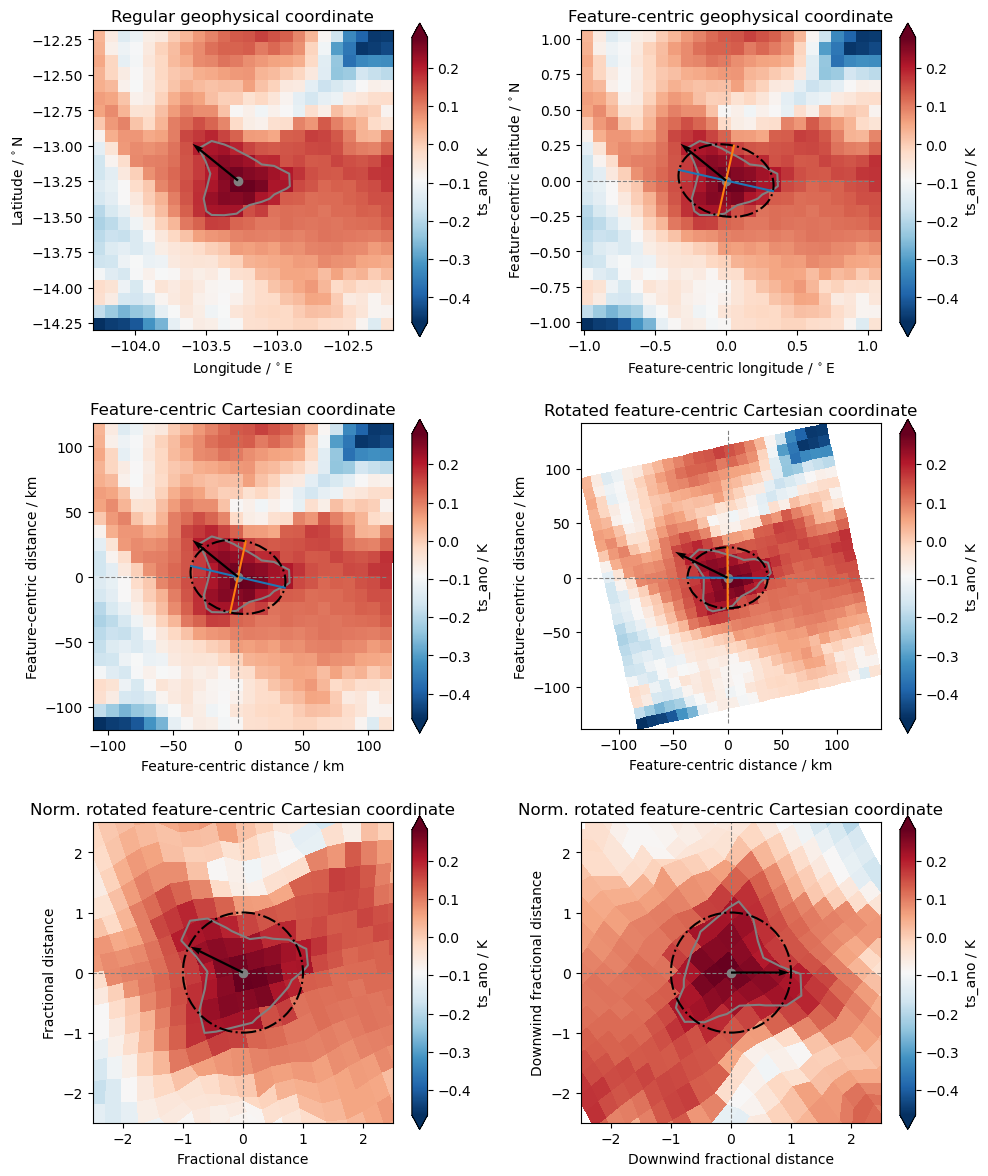

In [20]:
feature_id = 1
wind = feature_props[['bg_uas', 'bg_vas']]
pcplot.plot_coord_trafo(
    feature_data, feature_ellipse, wind, feature_id,
    f"{feature_var}_ano", config['feature']['threshold'],
    )

### Save data

In [8]:
analysis_identifier = f"{config['exp']}_{config['pycompo_name']}"

# save feature props
outpath = Path(f"{config['data']['outpath']}/{analysis_identifier}/")
outpath.mkdir(parents=True, exist_ok=True)
outfile = Path(
    f"{analysis_identifier}_feature_props_{start_time}-{end_time}.nc"
    )
feature_props.attrs["identifier"] = analysis_identifier
feature_props.to_netcdf(str(outpath/outfile))

# save feature data
outpath = Path(
    f"{config['data']['outpath']}/{analysis_identifier}/" + \
    f"{analysis_identifier}_feature_data_{start_time}-{end_time}/"
    )
outpath.mkdir(parents=True, exist_ok=True)

for data in feature_data[:3]:
    feature_id = data['feature_id'].values
    outfile = Path(
        f"{analysis_identifier}_feature_data_{start_time}-{end_time}_" + \
        f"feature{feature_id}.nc"
        )
    data.attrs["identifier"] = analysis_identifier
    data.drop(['height_2', 'uas', 'vas']).to_netcdf(str(outpath/outfile))

In [53]:
keep_vars = [f"{var}_ano" for var in config['data']['study_vars']] + \
[f"{feature_var}_ano", f"d{feature_var}_ano_dx", f"d{feature_var}_ano_dy",
 f"{feature_var}_ano_laplacian", f"{feature_var}_ano_feature", "uas", "vas"]
dset[keep_vars]

KeyError: 'ts_ano_feature'

### Create composite

In [33]:
def clean_feature_data(
        feature_data_in: list,
        feature_var: str,
        ) -> list:
    feature_data_out = []
    for data in feature_data_in:
        feature_data_out.append(
            data.where(~np.isnan(data[f'{feature_var}_laplacian']), np.NaN)
        )
    return feature_data_out
feature_data_test = clean_feature_data(feature_data, f"{feature_var}_ano")

In [44]:
import importlib, pycompo.core.composite

importlib.reload(pycompo.core.composite)
from pycompo.core.composite import interpolate2compo_coords

compo_varlst = [
    f"{feature_var}_ano", f"d{feature_var}_ano_dx", f"d{feature_var}_ano_dy",
    f"{feature_var}_ano_laplacian", "pr_ano", "prw_ano", "hfls_ano", "hfss_ano",
    ]
feature_compo_data = {
    var: interpolate2compo_coords(
        feature_data_test,
        (np.arange(*config['composite']['compo_x']),
         np.arange(*config['composite']['compo_y'])),
        var
        ) for var in compo_varlst
    }
feature_compo_data = xr.merge([feature_compo_data[var] for var in compo_varlst])

0


ValueError: Points cannot contain NaN

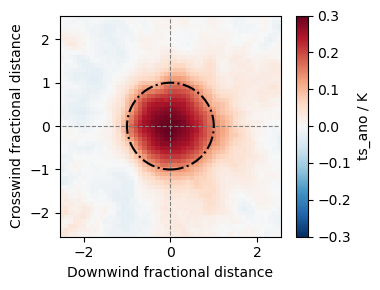

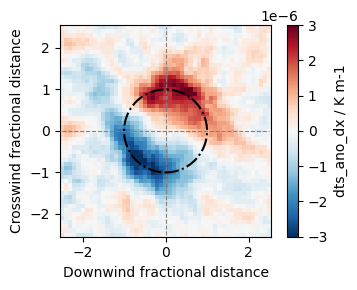

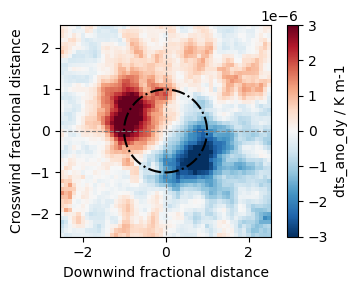

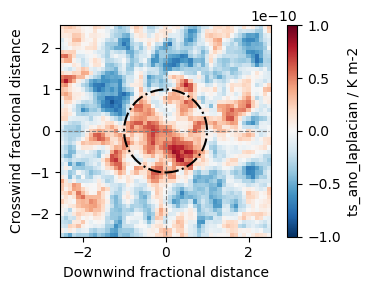

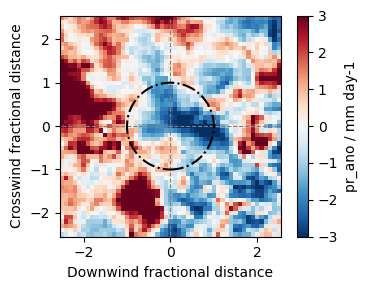

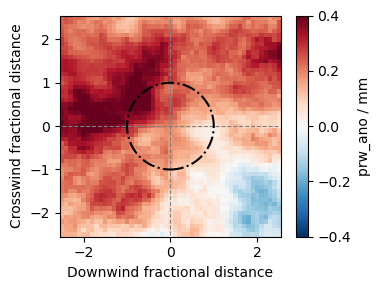

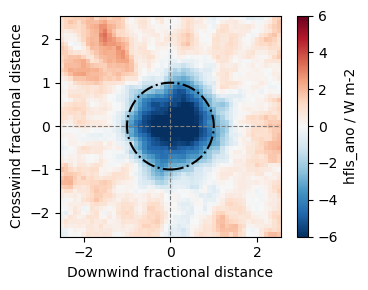

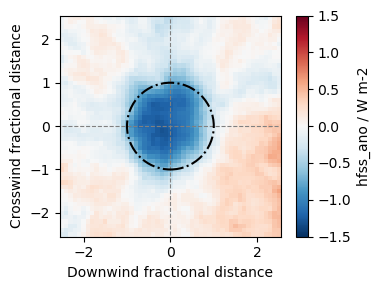

In [26]:
import importlib as implib
implib.reload(pcplot)

for var in compo_varlst:
    pcplot.plot_composite(feature_compo_data[var])